# 마스크 생성
- 얼굴 마스크와 턱라인 그은 마스크를 만들어서 합쳤습니다.

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

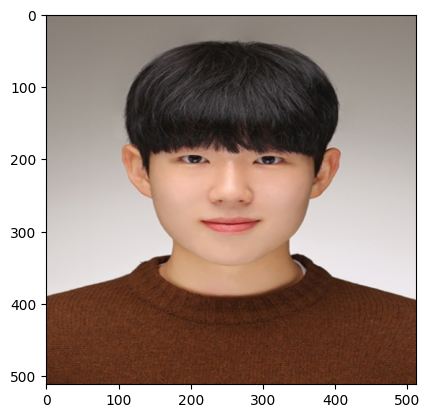

In [2]:
# 전역변수
global image_h
global image_w
global num_classes
global classes
global rgb_codes

# 파라미터
image_h = 512
image_w = 512
num_classes = 11
filename = "sample30"

# 이미지 불러오기
pic_path = f"C:\\data\\lapa\\LaPa\\results\\{filename}.jpg"
image = cv2.imread(pic_path, cv2.IMREAD_COLOR)
image = cv2.resize(image, (image_w, image_h))
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(512, 512, 3)


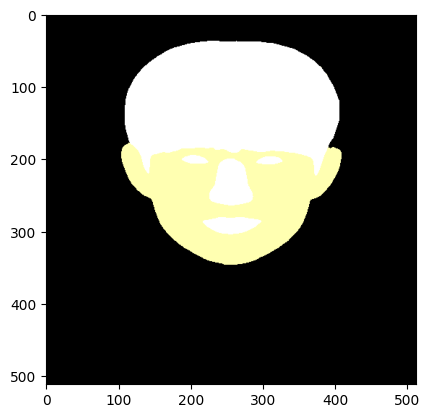

In [3]:
# RGB코드 적용하는 함수
def grayscale_to_rgb(mask, rgb_codes):
    h, w = mask.shape[0], mask.shape[1]
    mask = mask.astype(np.int32)  # rgb코드에 넣기위해서
    output = []

    for i, pixel in enumerate(mask.flatten()):
        output.append(rgb_codes[pixel])
    
    output = np.reshape(output, (h, w, 3))
    return output

# 시드
np.random.seed(42)
tf.random.set_seed(42)

# 경로
model_path = os.path.join("C:\\data\\lapa\\LaPa\\files", "model.h5")


# 클래스마다 다른 RGB 값
rgb_codes = [
    [0, 0, 0], [177, 255, 255], [255, 255, 255], [255, 255, 255],
    [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],
    [255, 255, 255], [255, 255, 255], [255, 255, 255]
]

# 클래스 종류 11개
classes = [
    "background", "skin", "left eyebrow", "right eyebrow",
    "left eye", "right eye", "nose", "upper lip", "inner mouth",
    "lower lip", "hair"
]

# 모델 불러오기
model = tf.keras.models.load_model(model_path, compile=False)

# 사진 스케일링
image = image/255.0  # (H, W, 3)
image = np.expand_dims(image, axis=0)  # [1, H, W, 3]
image = image.astype(np.float32)

# 사진 예측해서 마스크 생성
pred = model.predict(image, verbose=0)[0]
pred = np.argmax(pred, axis=-1)  # [0.1, 0.2, 0.1, 0.6] -> 3
pred = pred.astype(np.int32)
pred = np.expand_dims(pred, axis=-1)
pred = grayscale_to_rgb(pred, rgb_codes)

# 결과 저장
print(np.shape(pred))
b, g, r = cv2.split(pred)
img = cv2.merge([r,g,b])
plt.imshow(img)

라인이 적용되는 픽셀 위치: 353


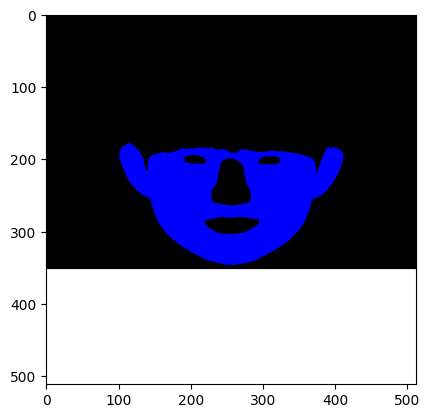

In [4]:
# 라인 마스크 생성
mask = pred
linemask = np.zeros((512, 512, 3), np.uint8)

chin_arr = []
# 턱 하단과 모델마스크 선까지의 거리 계산
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if (mask[j][i][0] == 177 and mask[j+3][i][0] == 177 and mask[j-3][i][0] == 177).all():
            chin_arr.append(j)
            cv2.line(linemask, (i, j), (i, j), (0, 0, 255), thickness=5)
            

dst = max(chin_arr)+10
print("라인이 적용되는 픽셀 위치:", dst)

cv2.rectangle(linemask, (0, dst), (512, 512), (255, 255, 255), cv2.FILLED)
plt.imshow(linemask)

# 파란 얼굴 지우기
for i in range(len(linemask)):
    for j in range(len(linemask[i])):
        if (linemask[j][i] == [0,0,255]).all():
            linemask[j][i] = [0,0,0]

(512, 512, 4) (512, 512, 4)


True

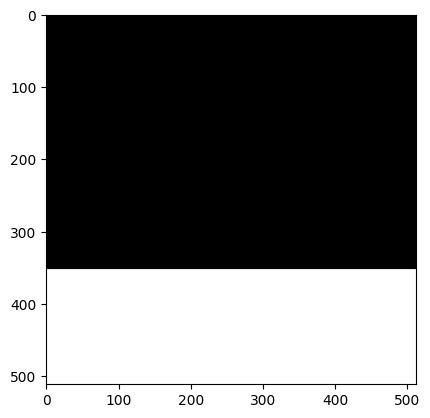

In [5]:
# 4채널로 만들어주기
linemask = linemask.astype('uint8')
linemask = cv2.cvtColor(linemask, cv2.COLOR_BGR2BGRA)
mask = mask.astype('uint8')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2BGRA)

print(np.shape(linemask), np.shape(mask))

# 얼굴 마스크의 배경을 투명하게 만들어서 라인 마스크에 붙이기
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if (mask[i][j][:3] == 0).all():
            mask[i][j] = [0, 0, 0, 0]

        if mask[i][j][3] == 255:
            mask[i][j] = [0, 0, 0, 255]

# 얼굴 마스크와 라인 마스크 합치기
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if mask[i][j][3] == 255:
            linemask[i][j] = mask[i][j] * linemask[i][j]
            linemask[i][j][3] = 255

plt.imshow(linemask)
cv2.imwrite(
    f'C:\\data\\lapa\\LaPa\\results\\merged_{filename}.png', linemask)
